<a href="https://colab.research.google.com/github/IanWilmutF09/Analisis-Data-dengan-Python/blob/main/Prediksi-Peningkatan-Suhu-Bumi/Prediksi_Peningkatan_Suhu_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preparation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to your file
file_path = '/content/drive/My Drive/Skripsi Yosef GH Drive/data_anomali_temperatur_ready.csv'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the file using pandas (for CSV files)
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Year  Month  Anomaly-Monthly  Unc-Monthly  Anomaly-Annual  Unc-Annual  \
0  1850      1           -0.790        0.404             NaN         NaN   
1  1850      2           -0.243        0.524             NaN         NaN   
2  1850      3           -0.394        0.449             NaN         NaN   
3  1850      4           -0.625        0.304             NaN         NaN   
4  1850      5           -0.652        0.249             NaN         NaN   

   Anomaly-Five-Year  Unc-Five-Year  Anomaly-Ten-Year  Unc-Ten-Year  \
0                NaN            NaN               NaN           NaN   
1                NaN            NaN               NaN           NaN   
2                NaN            NaN               NaN           NaN   
3                NaN            NaN               NaN           NaN   
4                NaN            NaN               NaN      

In [ ]:
# Menggabungkan kolom 'Year' dan 'Month' menjadi kolom 'time'
df['time'] = df['Year'].astype(str) + '-' + df['Month'].astype(str).str.zfill(2)

# Konversi kolom 'time' menjadi datetime
df['time'] = pd.to_datetime(df['time'], format='%Y-%m')

# Memilih hanya kolom 'time' dan Anomaly-Monthly
df = df[['time', 'Anomaly-Monthly']]

# Menampilkan DataFrame
print(df)

           time  Anomaly-Monthly
0    1850-01-01           -0.790
1    1850-02-01           -0.243
2    1850-03-01           -0.394
3    1850-04-01           -0.625
4    1850-05-01           -0.652
...         ...              ...
2086 2023-11-01            1.412
2087 2023-12-01            1.439
2088 2024-01-01            1.285
2089 2024-02-01            1.439
2090 2024-03-01            1.330

[2091 rows x 2 columns]


# **LSTM**

<ipython-input-26-e1f3afc8cccb>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Year'] = df_selected.index.year
<ipython-input-26-e1f3afc8cccb>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Month'] = df_selected.index.month
<ipython-input-26-e1f3afc8cccb>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

Epoch 1/100
28/28 [==============================] - 2s 8ms/step - loss: 0.1338
Epoch 2/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0262
Epoch 3/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0114
Epoch 4/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0104
Epoch 5/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0103
Epoch 6/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0097
Epoch 7/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0092
Epoch 8/100
28/28 [==============================] - 0s 8ms/step - loss: 0.0087
Epoch 9/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0080
Epoch 10/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 11/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0084
Epoch 12/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0085
Epoch 13/100
28/28 [=================

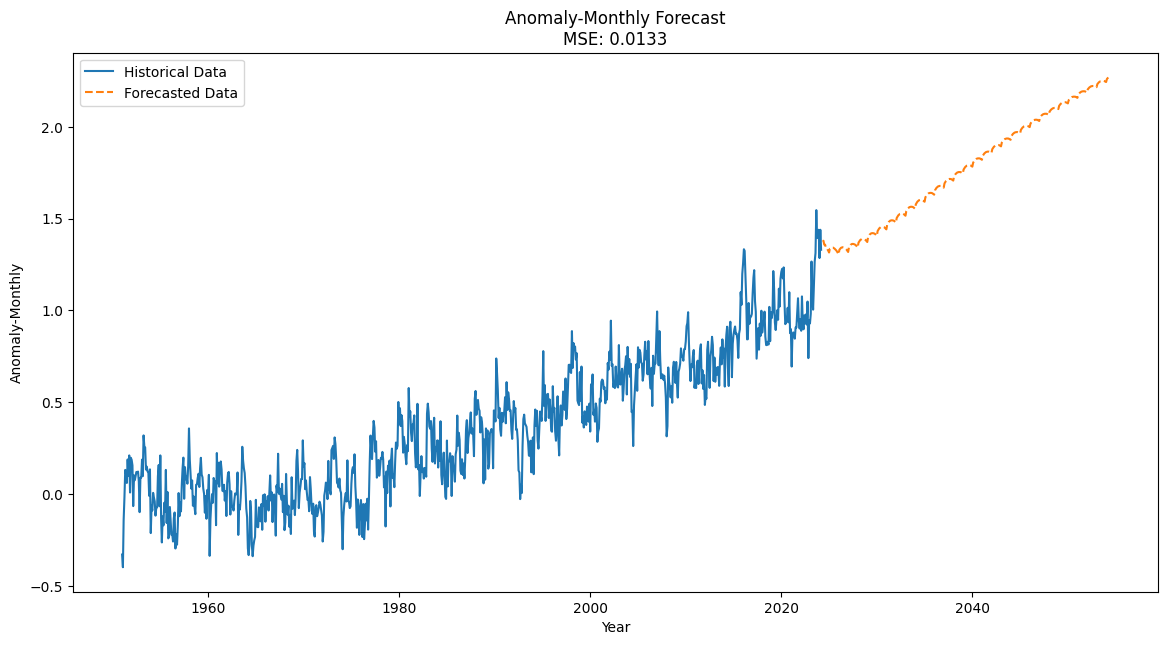

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np

# Set 'time' sebagai index
df.set_index('time', inplace=True)

# Select data up to 2024-03-01
df_selected = df['1950-01-01':'2024-03-01']

# Feature Engineering
df_selected['Year'] = df_selected.index.year
df_selected['Month'] = df_selected.index.month

# Create lag features
for lag in range(1, 13):  # Adding lag features for the past 12 months
    df_selected[f'Lag_{lag}'] = df_selected['Anomaly-Monthly'].shift(lag)

# Drop missing values created by lag features
df_selected.dropna(inplace=True)

# Prepare feature matrix X and target vector y
features = ['Year', 'Month'] + [f'Lag_{lag}' for lag in range(1, 13)]
X = df_selected[features].values
y = df_selected['Anomaly-Monthly'].values

# Normalize the features and target variable
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Reshape X for LSTM model (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Build the LSTM model with two layers
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_scaled.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model with RMSprop optimizer
optimizer = RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Train the model
model.fit(X_scaled, y_scaled, epochs=100, batch_size=32)

# Prepare to predict the next 30 years (360 months)
future_periods = 360
future_dates = pd.date_range(start=df_selected.index[-1] + pd.DateOffset(months=1), periods=future_periods, freq='M')
future_df = pd.DataFrame(index=future_dates)

# Feature Engineering for future data
future_df['Year'] = future_df.index.year
future_df['Month'] = future_df.index.month

# Initialize with the last known data
last_known = df_selected.iloc[-1].to_dict()
for lag in range(1, 13):
    future_df[f'Lag_{lag}'] = np.nan
    if lag <= len(df_selected):
        future_df.iloc[0, future_df.columns.get_loc(f'Lag_{lag}')] = last_known[f'Lag_{lag}']

# Add 'Anomaly-Monthly' column to future_df
future_df['Anomaly-Monthly'] = np.nan

# Predict future values month by month
predictions = []
for i in range(future_periods):
    # Prepare the feature matrix for prediction
    X_future = future_df.iloc[i:i+1][features].values
    X_future_scaled = scaler_X.transform(X_future)
    X_future_scaled = X_future_scaled.reshape((X_future_scaled.shape[0], 1, X_future_scaled.shape[1]))

    # Predict the next value
    y_future_scaled = model.predict(X_future_scaled)
    y_future = scaler_y.inverse_transform(y_future_scaled)

    predictions.append(y_future[0, 0])

    # Update the future_df with the predicted value
    if i + 1 < future_periods:
        future_df.iloc[i + 1, future_df.columns.get_loc('Anomaly-Monthly')] = y_future[0, 0]
        for lag in range(1, 12):
            future_df.iloc[i + 1, future_df.columns.get_loc(f'Lag_{lag+1}')] = future_df.iloc[i, future_df.columns.get_loc(f'Lag_{lag}')]
        future_df.iloc[i + 1, future_df.columns.get_loc('Lag_1')] = y_future[0, 0]

# Create a DataFrame to store future predictions
future_df['Anomaly-Monthly'] = predictions

# Calculate MSE for the historical data (last 5% used as test data)
test_size = int(0.05 * len(df_selected))
X_test = X_scaled[-test_size:]
y_test = y_scaled[-test_size:]

y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

mse = mean_squared_error(y_test_original, y_pred)
print('MSE:', mse)

# Combine historical and future data for plotting
combined_df = pd.concat([df_selected['Anomaly-Monthly'], future_df['Anomaly-Monthly']], axis=0)

# Plot the historical data
plt.figure(figsize=(14, 7))
plt.plot(df_selected.index, df_selected['Anomaly-Monthly'], label='Historical Data')

# Plot the forecasted data
plt.plot(future_df.index, future_df['Anomaly-Monthly'], label='Forecasted Data', linestyle='dashed')

# Add titles, labels, and MSE value
plt.title('Anomaly-Monthly Forecast\nMSE: {:.4f}'.format(mse))
plt.xlabel('Year')
plt.ylabel('Anomaly-Monthly')
plt.legend()

# Display the plot
plt.show()

In [ ]:
# Create a DataFrame to store predictions with their corresponding dates
forecast_table = pd.DataFrame({
    "Date": future_df.index,
    "Forecasted Anomaly": future_df["Anomaly-Monthly"]
})

# Display the forecast table
print("Forecast Table:")
print(forecast_table.to_string(index=False))

Forecast Table:
      Date  Forecasted Anomaly
2024-04-30            1.377382
2024-05-31            1.379191
2024-06-30            1.358235
2024-07-31            1.357879
2024-08-31            1.342746
2024-09-30            1.341520
2024-10-31            1.332183
2024-11-30            1.324925
2024-12-31            1.315131
2025-01-31            1.335774
2025-02-28            1.337995
2025-03-31            1.342780
2025-04-30            1.342031
2025-05-31            1.341989
2025-06-30            1.339099
2025-07-31            1.335985
2025-08-31            1.331549
2025-09-30            1.326835
2025-10-31            1.320576
2025-11-30            1.313194
2025-12-31            1.305182
2026-01-31            1.330348
2026-02-28            1.335182
2026-03-31            1.340504
2026-04-30            1.342149
2026-05-31            1.343906
2026-06-30            1.342889
2026-07-31            1.341467
2026-08-31            1.338791
2026-09-30            1.335609
2026-10-31            1

# **LSTM: Yearly Average of Forecasting**

Average Anomaly Temperature in 2030: 1.4479079047838848
Average Anomaly Temperature in 2050: 2.158868749936422


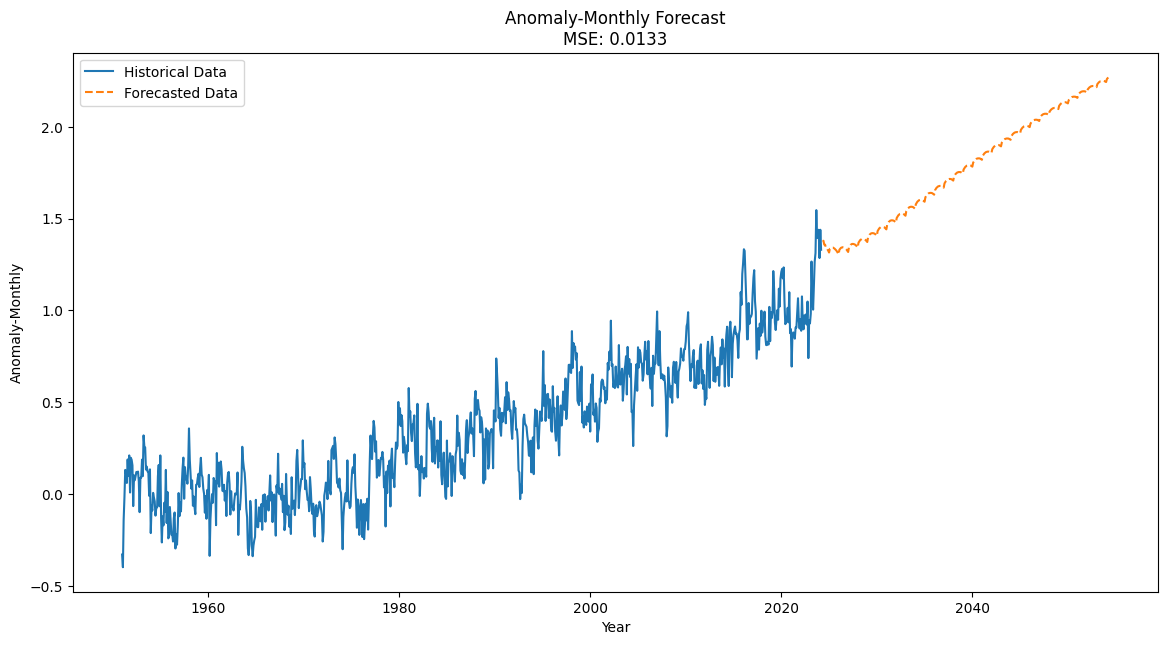

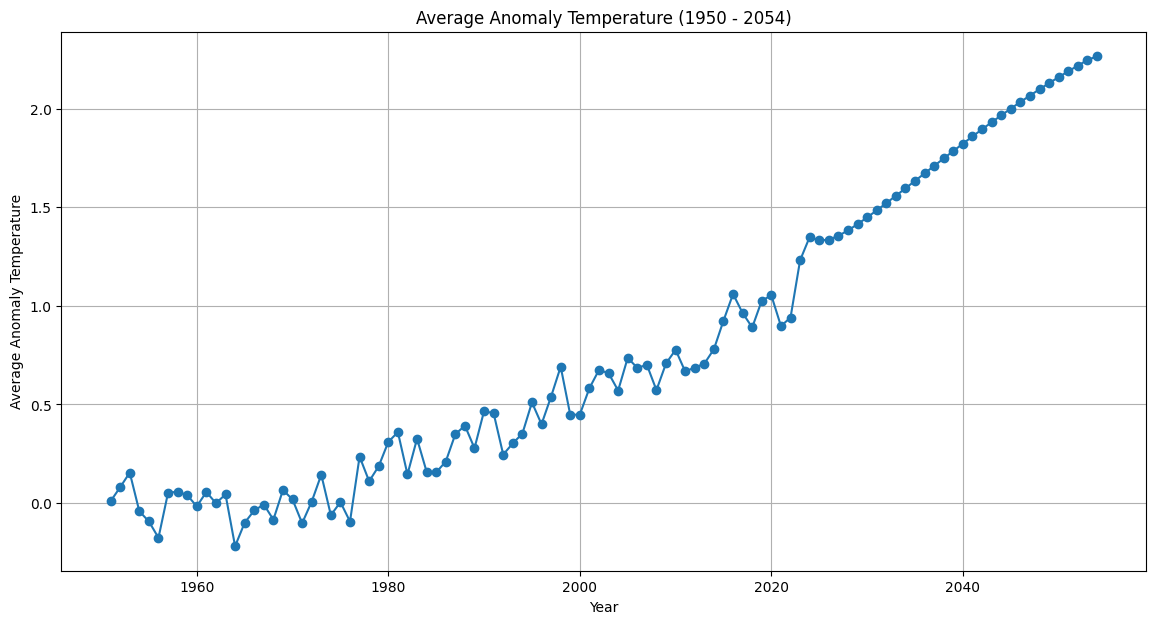

In [ ]:
# Calculate the average anomaly temperature for each year from 1950 to the end of forecasted period
years = combined_df.index.year.unique()
average_anomalies = []

for year in years:
    yearly_data = combined_df[str(year)]
    average_anomaly = yearly_data.mean()
    average_anomalies.append(average_anomaly)

# Create a DataFrame for the average anomalies
average_anomalies_df = pd.DataFrame({'Year': years, 'Average Anomaly': average_anomalies})

# Print the average anomalies for the years 2030 and 2050
average_anomaly_2030 = average_anomalies_df[average_anomalies_df['Year'] == 2030]['Average Anomaly'].values[0]
average_anomaly_2050 = average_anomalies_df[average_anomalies_df['Year'] == 2050]['Average Anomaly'].values[0]

print(f'Average Anomaly Temperature in 2030: {average_anomaly_2030}')
print(f'Average Anomaly Temperature in 2050: {average_anomaly_2050}')

# Plot the historical data
plt.figure(figsize=(14, 7))
plt.plot(df_selected.index, df_selected['Anomaly-Monthly'], label='Historical Data')

# Plot the forecasted data
plt.plot(future_df.index, future_df['Anomaly-Monthly'], label='Forecasted Data', linestyle='dashed')

# Add titles, labels, and MSE value
plt.title('Anomaly-Monthly Forecast\nMSE: {:.4f}'.format(mse))
plt.xlabel('Year')
plt.ylabel('Anomaly-Monthly')
plt.legend()

# Display the plot
plt.show()

# Plot the average anomalies over the years
plt.figure(figsize=(14, 7))
plt.plot(average_anomalies_df['Year'], average_anomalies_df['Average Anomaly'], marker='o', linestyle='-')
plt.title('Average Anomaly Temperature (1950 - 2054)')
plt.xlabel('Year')
plt.ylabel('Average Anomaly Temperature')
plt.grid(True)
plt.show()